<h2>BACKGROUND AND CONTEXT</h2>


Note this file was created using Python version 3.13

The purpose of this project is to analyse the seattle dataset of properties and prices.  I will apply the CRISP-DM process.

        CRISP-DM Process:
        1. Business Understanding - understand the business problem
        2. Data Understanding - understand the data
        3. Prepare Data - data cleaning, data transformation
        4. Data Modeling - create models to answer the questions
        5. Evaluate the Results - evaluate the models
        6. Deploy - deploy the models




<h2>Step 1 - Understand The Business Problem</h2>

We are looking at the Seattle Dataset.  I am going to imagine a business problem where a client that is a developer of properties wants to buy a property in Seattle and is interested in the rental prices they can obtain.

I will get a list of properties and examples features and prices of properties by neighbourhood and using this tell the client what they can expect by analysing themes and correlations between features of properties in the top neighbourhood (can extend to others easily) and price.  I will also create a predictive model provided the example data is reliable enough to estimate prices accurately.  If not, then I will advise the client with ranges of prices based on properties in the example dataset.

<h2>Step 2 and 3 - Understand the Data and Prepare Data</h2>


<h3>Import Libraries and Files</h3>

In [24]:

import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#import AllTogether as t
import seaborn as sns
%matplotlib inline

# functions

def create_chart(data, xlabel, ylabel, title):
    
    sns.histplot(data, bins=30, kde=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def create_scatter_plot(x, y, xlabel, ylabel, title):
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

def read_datafile_from_github (filenamezip, filenamewithoutzip):
    # Link to the raw ZIP file on GitHub
    url = filenamezip

    # Download the ZIP file
    response = requests.get(url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))

    # Read the CSV file inside the ZIP into a DataFrame
    with zip_file.open(filenamewithoutzip) as file:
        return pd.read_csv(file)


#There are 3 files we will download - descriptions have been 
# taken from Kaggle website (https://www.kaggle.com/datasets/airbnb/seattle/data):
# listings which includes full descriptions and average review scores
# reviews which includes the unique id for each reviewer and comments
# reviews which includes the listing id and the price and avilability for the day
# I have saved in my GitHub account and will download from there

#READ THE LISTINGS FILE

# Link to the raw ZIP file on GitHub
url = "https://github.com/ommarhannan/seattledata/raw/main/listings.csv.zip"

# Download the ZIP file
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Read the CSV file inside the ZIP into a DataFrame
with zip_file.open('listings.csv') as file:
    listings_df = pd.read_csv(file)


#READ THE CALENDAR FILE

# Link to the raw ZIP file on GitHub
url = "https://github.com/ommarhannan/seattledata/raw/main/calendar.csv.zip"

# Download the ZIP file
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Read the CSV file inside the ZIP into a DataFrame
with zip_file.open('calendar.csv') as file:
    calendar_df = pd.read_csv(file)


# READ THE REVIEWS FILE

# Link to the raw ZIP file on GitHub
url = "https://github.com/ommarhannan/seattledata/raw/main/reviews.csv.zip"

# Download the ZIP file
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Read the CSV file inside the ZIP into a DataFrame
with zip_file.open('reviews.csv') as file:
    reviews_df = pd.read_csv(file)



<h2>Initial exploratory analysis</h2>

CLEAN DATA SO WE CAN EXPLORE

In [2]:
#CLEAN CALENDAR TABLE
#1. Convert date to date

calendar_df['date'] = pd.to_datetime(calendar_df['date'])

#2. Convert available to boolean

calendar_df['available'] = calendar_df['available'].str.replace('t', 'True')
calendar_df['available'] = calendar_df['available'].str.replace('f', 'False')
calendar_df['available'] = calendar_df['available'].astype(bool)

#3. Convert price to float

calendar_df['price'] = calendar_df['price'].str.replace('$', '')
calendar_df['price'] = calendar_df['price'].str.replace(',', '')
calendar_df['price'] = calendar_df['price'].astype(float)



In [3]:
#CLEAN REVIEWS TABLE

#1. Convert date to date
reviews_df['date'] = pd.to_datetime(reviews_df['date'])


In [4]:
#CLEAN LISTINGS TABLE

#1. Convert price to float
listings_df['price'] = listings_df['price'].str.replace('$', '')
listings_df['price'] = listings_df['price'].str.replace(',', '')
listings_df['price'] = listings_df['price'].astype(float)


#2. Convert lower case seattle in city to Seattle
listings_df['city'] = listings_df['city'].str.strip()
listings_df['city'] = listings_df['city'].str.replace('seattle', 'Seattle')

#3. Clean number of bedrooms column to drop rows where na
#listings_df=listings_df.dropna(subset=['bedrooms'])

#4. I noticed fron earlier exploratory analysis of each column that square feet column is blank for any rows.  This appears to be
# and important column.  From researching on the web, a bedroom in Seattle is on average 120 to 200 square feet.  I will use the 
# average of 160 square feet for the missing values.

listings_df['square_feet'] = listings_df['square_feet'].fillna(160*listings_df['bedrooms'])


POTENTIAL QUESTIONS WE CAN ASK:

1. WHICH AREAS OF SEATTLE HAVE THE HIGHEST RENTALS?
2. WHICH NEIGHBOURHOODS HAVE THE HIGHEST RENTALS?
3. PICKING THE TOP NEIGHTBOURHOODS ANY COMMON THEMES WHICH TYPE OF PROPERTY HAS THE HIGHEST RENTAL?
4. CREATE A PREDICTIVE MODEL FOR THE PRICE BASED ON THE MOST COMMON THEMES THAT IMPACT RENTAL PRICE

1. WHICH AREAS OF SEATTLE HAVE THE HIGHEST RENTALS?

In [5]:
# Get distribution of prices by city

# from data below we can see not that useful as only a few cities are represented.

listings_df.groupby('city')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
"Ballard, Seattle",1.0,116.00000,NaN,116.0,116.0,116.0,116.0,116.0
Phinney Ridge Seattle,1.0,60.00000,NaN,60.0,60.0,60.0,60.0,60.0
Seattle,3813.0,128.03016,90.288394,20.0,75.0,100.0,150.0,1000.0
West Seattle,2.0,110.00000,28.284271,90.0,100.0,110.0,120.0,130.0
西雅图,1.0,38.00000,NaN,38.0,38.0,38.0,38.0,38.0


2. WHICH NEIGHBOURHOODS HAVE THE HIGHEST RENTALS?

    From the below, we can see that the Magnolia and Queen Anne neighbourhoods have highest rentals but interestin that looking at the median value (50%), then Downtown is highest followed by Magnolia.  I will focus on these two locations.


In [6]:
listings_df.groupby('neighbourhood_group_cleansed')['price'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Magnolia,61.0,177.672131,150.078726,30.0,78.0,129.0,225.00,950.0
Queen Anne,295.0,157.223729,115.863385,20.0,95.0,119.0,175.00,975.0
Downtown,530.0,154.405660,90.902800,35.0,105.0,139.0,175.00,999.0
West Seattle,203.0,141.359606,89.147801,30.0,79.0,109.0,195.00,495.0
Cascade,89.0,140.101124,112.179042,42.0,88.0,115.0,141.00,775.0
Capitol Hill,567.0,130.592593,92.442331,22.0,80.0,105.0,150.00,750.0
Central Area,369.0,128.338753,80.260558,35.0,75.0,100.0,155.00,500.0
Ballard,230.0,124.682609,87.925033,25.0,70.0,95.0,149.00,475.0
Other neighborhoods,794.0,119.968514,86.580450,25.0,66.0,99.0,145.00,1000.0


3. PICKING THE TOP NEIGHBOURHOODS IS THERE ANY COMMON THEMES WHICH TYPE OF PROPERTY HAS THE HIGHEST RENTAL?

In [7]:
# let's look at the properties in Magnolia where price is greater than 200 for any themes
magnolia_df = listings_df[listings_df['neighbourhood_group_cleansed'] == 'Magnolia']
magnolia_top_df = magnolia_df[magnolia_df['price'] > 200]

fields_of_interest = ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'square_feet', 'review_scores_value', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_checkin']
magnolia_top_df[fields_of_interest]

,price,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,square_feet,review_scores_value,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_checkin
1164,229.0,7,2.0,3.0,3.0,4,100.0,480.0,10.0,10.0,10.0,10.0,10.0,10.0
1165,333.0,10,3.5,3.0,5.0,29,94.0,480.0,10.0,10.0,10.0,10.0,9.0,10.0
1171,350.0,12,3.5,5.0,7.0,3,100.0,800.0,10.0,9.0,9.0,10.0,9.0,9.0
1173,225.0,5,2.5,3.0,3.0,9,98.0,480.0,10.0,10.0,10.0,10.0,10.0,10.0
1180,250.0,6,2.0,3.0,4.0,2,100.0,480.0,10.0,10.0,10.0,10.0,10.0,10.0
1186,280.0,5,2.0,3.0,2.0,2,80.0,480.0,8.0,10.0,10.0,9.0,10.0,10.0
1189,480.0,8,1.0,5.0,5.0,0,NaN,800.0,NaN,NaN,NaN,NaN,NaN,NaN
1196,225.0,5,2.0,2.0,2.0,14,100.0,320.0,10.0,10.0,10.0,10.0,10.0,10.0
1198,250.0,6,1.5,2.0,4.0,4,100.0,320.0,10.0,10.0,10.0,10.0,10.0,10.0
1204,350.0,12,3.5,5.0,7.0,1,100.0,800.0,10.0,10.0,10.0,10.0,10.0,10.0


In [8]:
# let's look at the properties in Magnolia where price is less than 100 for any themes

magnolia_bottom_df = magnolia_df[magnolia_df['price'] < 100]
magnolia_bottom_df[fields_of_interest]

,price,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,square_feet,review_scores_value,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_checkin
1166,41.0,1,1.0,1.0,1.0,57,89.0,160.0,9.0,9.0,9.0,10.0,9.0,9.0
1167,70.0,2,1.0,1.0,1.0,39,98.0,160.0,10.0,10.0,10.0,10.0,10.0,10.0
1168,55.0,1,1.0,1.0,1.0,0,NaN,160.0,NaN,NaN,NaN,NaN,NaN,NaN
1169,70.0,2,1.0,1.0,2.0,20,86.0,160.0,8.0,8.0,9.0,9.0,9.0,9.0
1170,97.0,4,1.0,1.0,2.0,0,NaN,160.0,NaN,NaN,NaN,NaN,NaN,NaN
1175,40.0,2,1.0,1.0,1.0,58,94.0,160.0,10.0,9.0,10.0,10.0,9.0,10.0
1177,46.0,2,1.0,1.0,1.0,25,91.0,160.0,9.0,9.0,10.0,10.0,9.0,10.0
1178,64.0,2,1.0,1.0,1.0,57,97.0,160.0,10.0,10.0,10.0,10.0,9.0,10.0
1182,30.0,1,1.0,1.0,1.0,16,97.0,160.0,9.0,9.0,10.0,10.0,10.0,10.0
1184,78.0,2,1.0,1.0,1.0,0,NaN,160.0,NaN,NaN,NaN,NaN,NaN,NaN


Let's create scatterplots for the fields of interest to see if any interesting correlations.  What we see is that the following fields have a stronger correlation with price: number of accommodates, number of bedrooms, review scores rating, review scores value,
review scores cleanliness, review scores checkin, review scores communication, review scores location

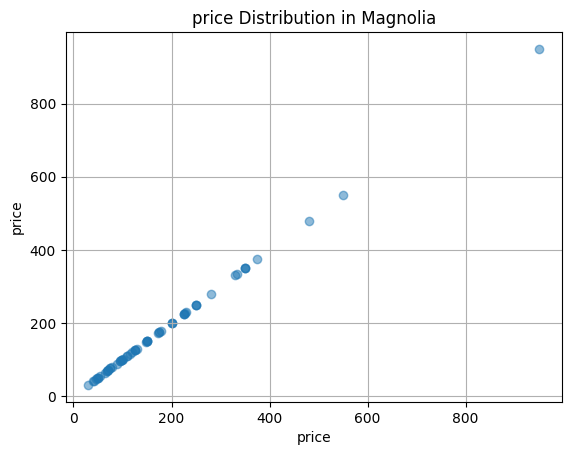

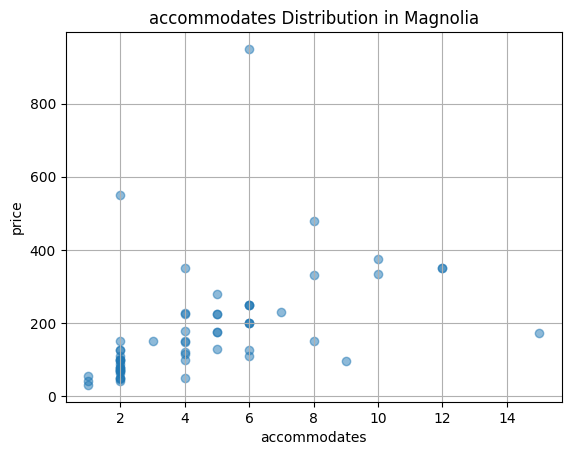

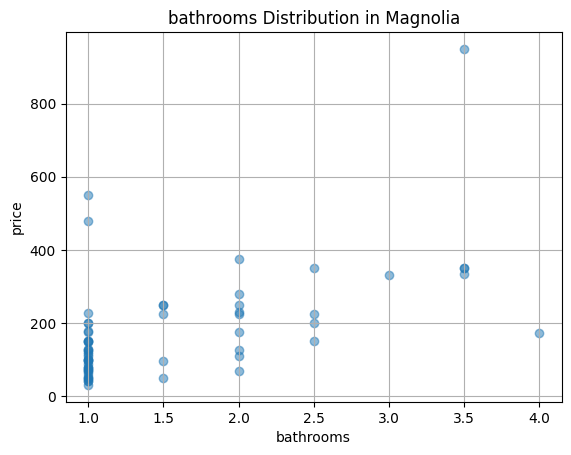

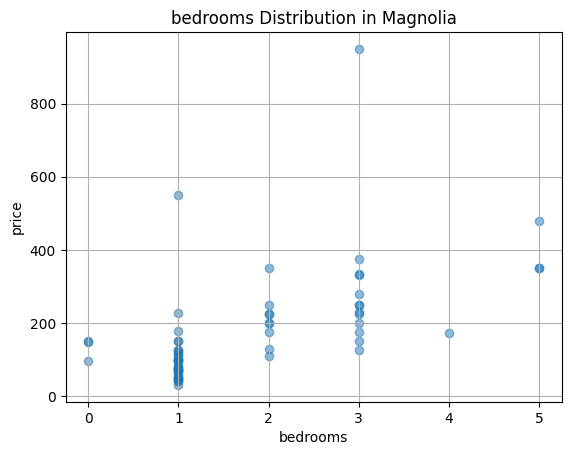

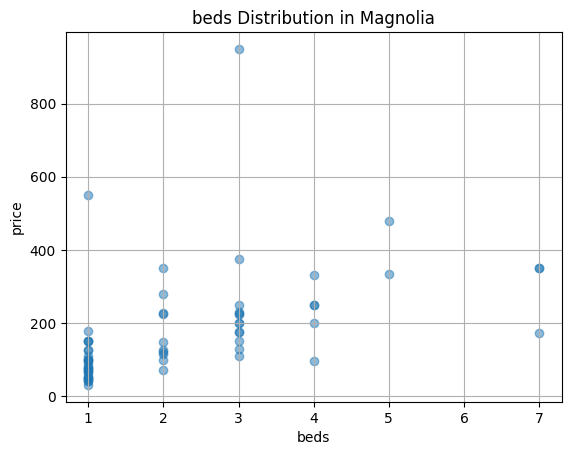

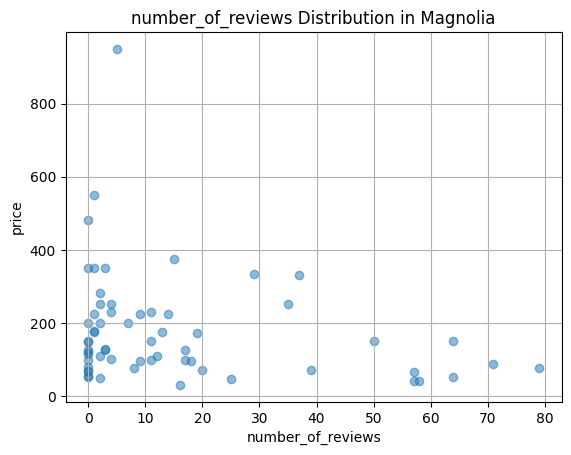

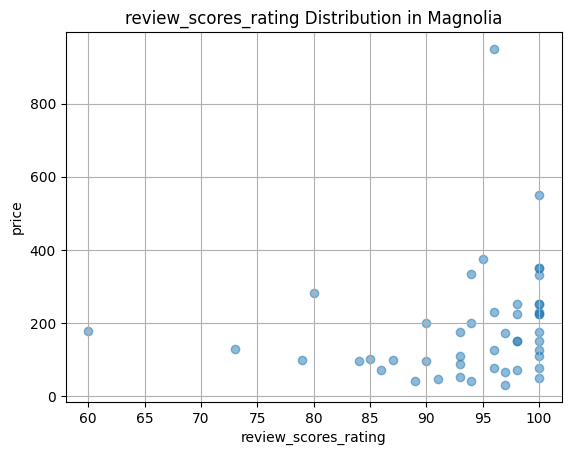

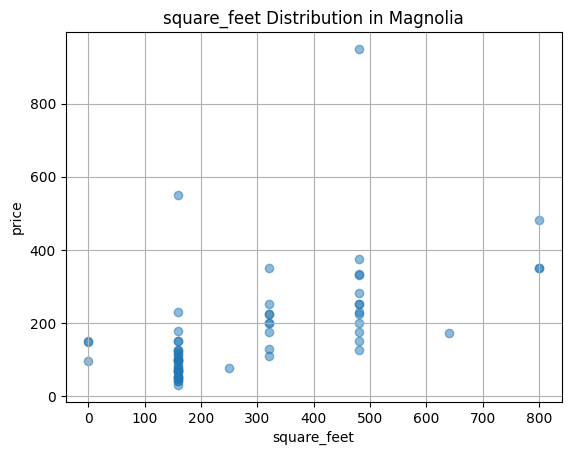

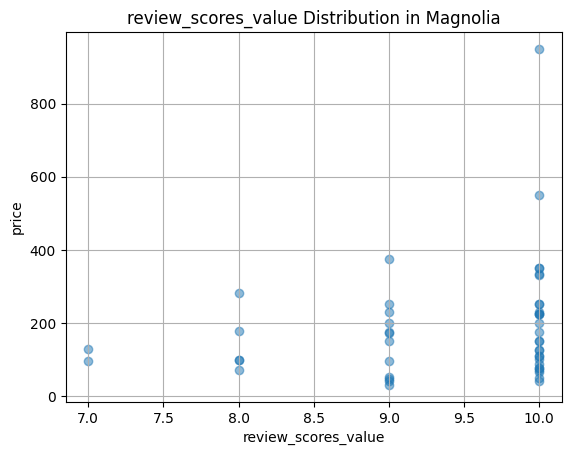

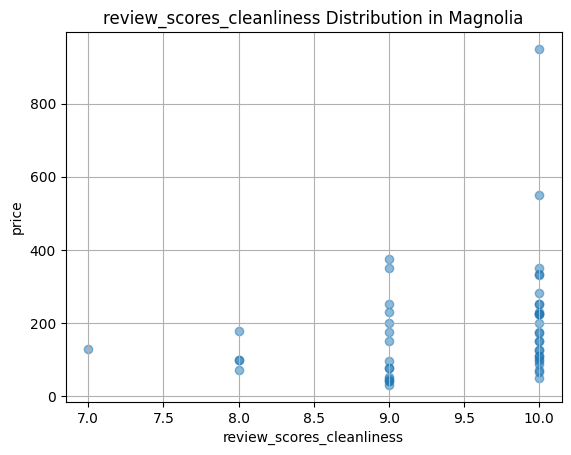

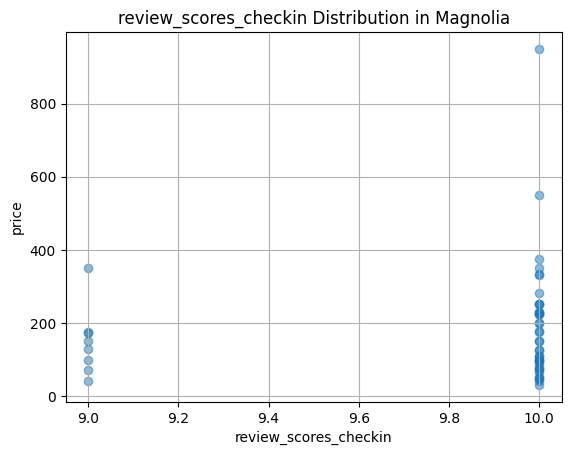

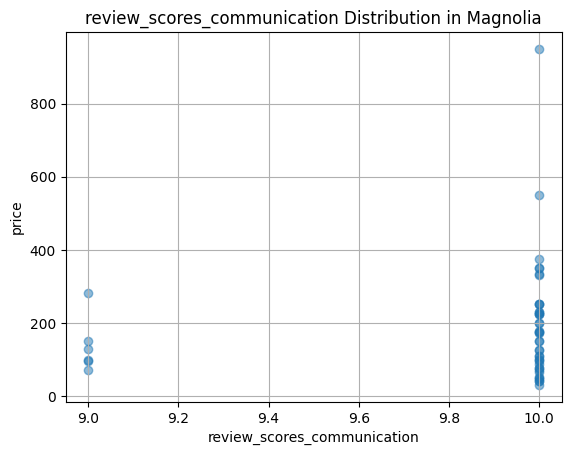

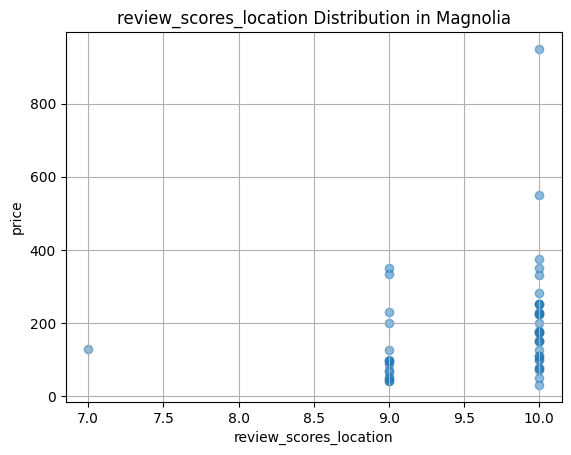

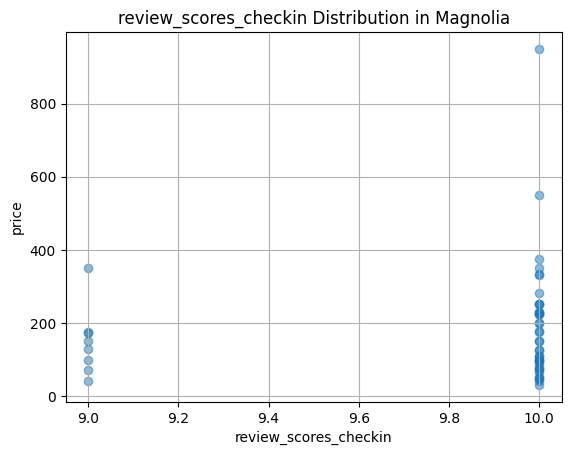

In [9]:

for item in fields_of_interest:
    create_scatter_plot(magnolia_df[item], magnolia_df['price'], f'{item}', 'price', f'{item} Distribution in Magnolia')



Let's check the r2 for each of these fields of interest to see correlation

What we observe is that the following variables have stronger correlations to price:
- Accommodates
- Bathrooms
- Bedrooms
- Beds
- Square feet

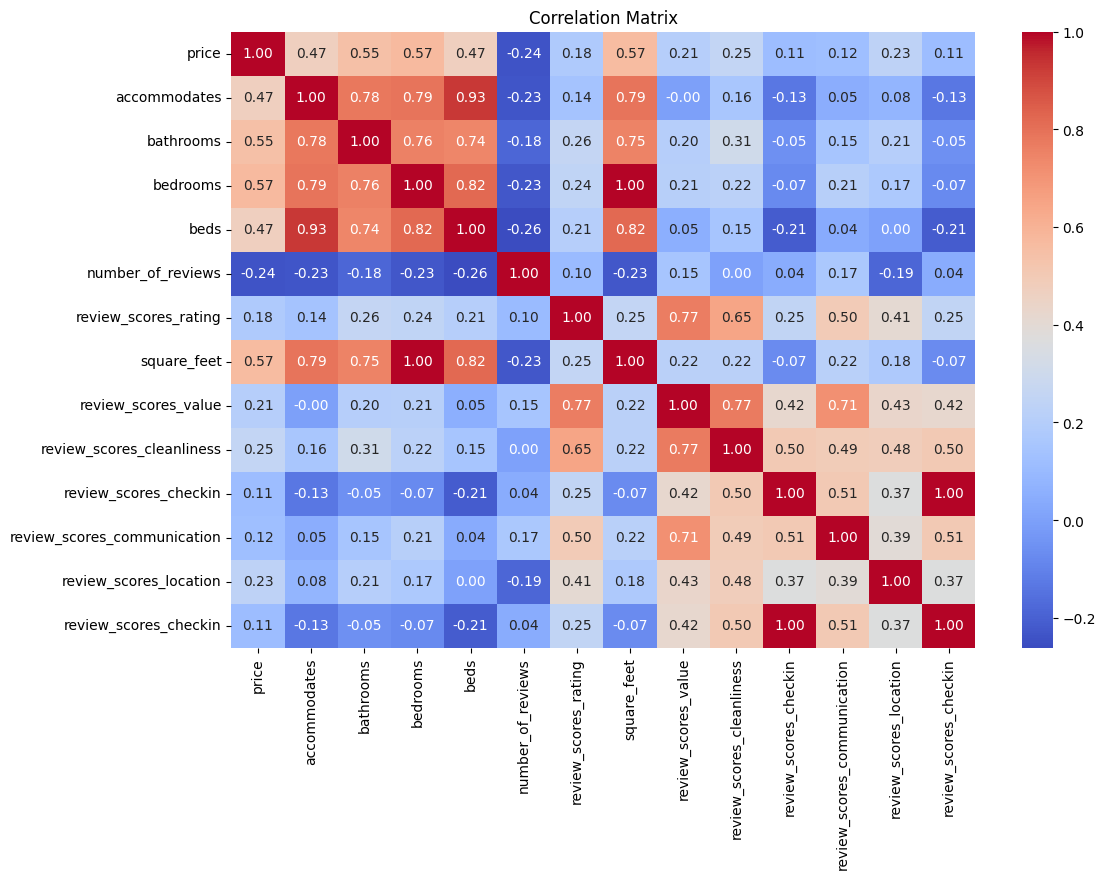

In [10]:
# Filter the DataFrame to include only the columns of interest
filtered_df = magnolia_df[fields_of_interest]

# Compute the correlation matrix
correlation_matrix = filtered_df.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

<h2>Step 4 and 5 - Data Modelling and Evaluate Results</h2>

<h3>Now create a predictive model based on the variables that have a stronger correlation with price</h3>

First clean the filtered dataframe of listings_df that has columms I am interested in
In checking the data frame, the square feet column has too many missing values so dropping it
For the other columns, I will fill with average values of the column

In [11]:
#Check for missing values.  There are none for the fields we want to model so good to use for predictive modelling

missing_values = listings_df[fields_of_interest].isnull().sum()
print(f"Missing values: {missing_values}")

Missing values: price                            0
accommodates                     0
bathrooms                       16
bedrooms                         6
beds                             1
number_of_reviews                0
review_scores_rating           647
square_feet                      6
review_scores_value            656
review_scores_cleanliness      653
review_scores_checkin          658
review_scores_communication    651
review_scores_location         655
review_scores_checkin          658
dtype: int64


I played with different versions of the columns of interest above.  Based on experimenting, I found using: accommodates, bedrooms and beds gets me to an r2 of 0.45.  This is what I will use to predict price going forward although not a strong correlation.

In [12]:


#features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']
features = ['accommodates', 'bedrooms', 'beds']
target = 'price'

# Drop rows with missing values in the selected columns
listings_df = listings_df.dropna(subset=features + [target])

# Define X (features) and y (target)
X = listings_df[features]
y = listings_df[target]

# Split the data into training and testing subsets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Optional: Display model coefficients
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)

Mean Squared Error: 4353.395951968559
R-squared: 0.4500082470238982
        Feature  Coefficient
0  accommodates    18.740461
1      bedrooms    31.350221
2          beds     1.806315


In [13]:
accommodate_value = 5
bedrooms_value = 3
bed_value = 3
square_feet_value = 160*bedrooms_value

#newX_parameters = [accommodate_value, bedrooms_value, bed_value]
feature_values = pd.DataFrame([[accommodate_value, bedrooms_value, bed_value]], 
                               columns=['accommodates', 'bedrooms', 'beds'])
y_value = model.predict(feature_values)
print(f"Predicted house price based on {accommodate_value} accommodation, {bedrooms_value} bedrooms, {bed_value} beds is: {y_value}")



Predicted house price based on 5 accommodation, 3 bedrooms, 3 beds is: [214.62859232]


Text(0, 0.5, 'Actual Price')

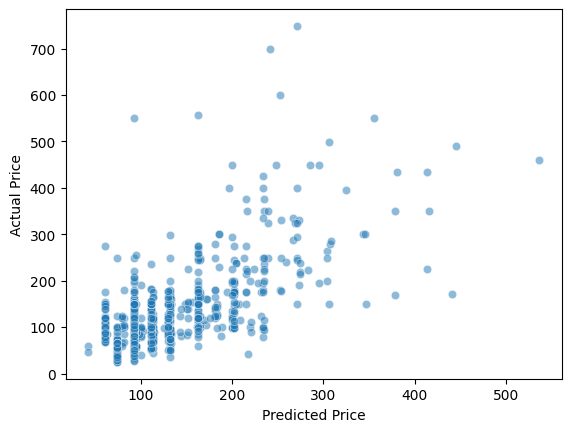

In [14]:
sns.scatterplot(x=y_pred, y=y_test, alpha=0.5)
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")

From the r2 score of the model and visualised scatterplot in the chart above, the model is not sufficiently accurate despite cleaning to accurately predict price.  To meet client's needs, I will take another approach which is to look at the key features of interest at different price ranges and give them insights on that basis.

In [15]:
# I want to create a new column called price_rounded which shows price rounded to nearest 50.  This keeps banding sufficiently narrow
# to be insightful

listings_df['price_rounded'] = (listings_df['price'] / 50).round() * 50

In [16]:
# now group by neighbourhood and price_rounded and look at the key features that I found correlations when looking
# at the magnolia data and correlation matrix above.  Take the mean of these features.  Reset index to create a dataframe of results.

listings_df_revised = listings_df.groupby(['neighbourhood_group_cleansed', 'price_rounded'])[['accommodates', 'bathrooms', 'bedrooms', 'beds']].mean().reset_index()
listings_df_revised.set_index('neighbourhood_group_cleansed', inplace=True)


Let's create a correlation matrix based on the listings_df_revised dataframe which has the rounded price ranges and key features such as number of people accommodated, bathrooms, bedrooms and beds.   What I see is that bathrooms and accommodates has a stronger correlation with price.

It is more logical that number of people accommodated in an appartment or property would have stronger link to price.  I will focus on that in summarising for the client the prices to expect based on number of people accommodated.

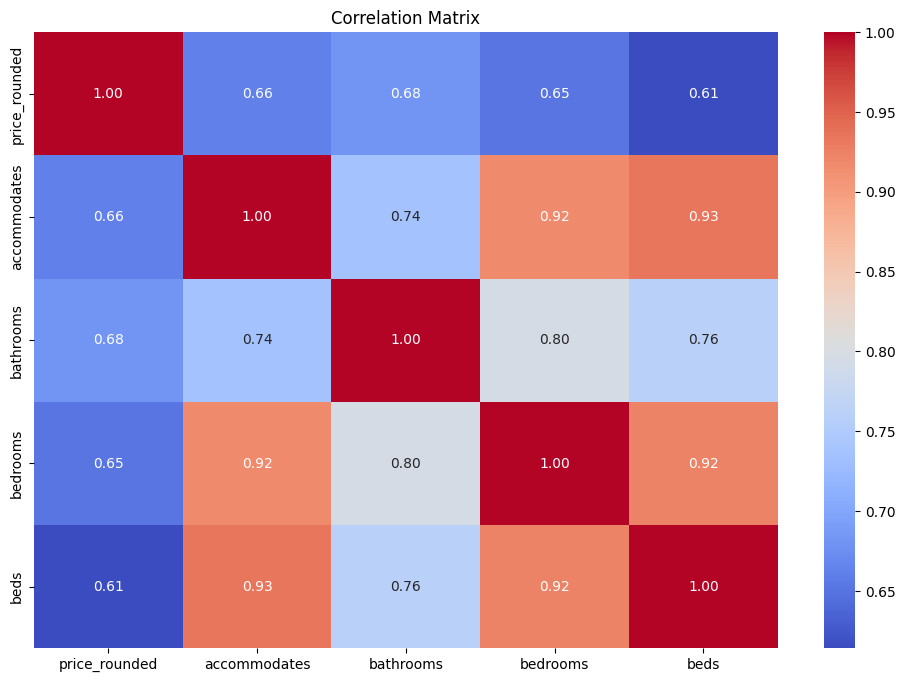

In [17]:
# Compute the correlation matrix
correlation_matrix = listings_df_revised.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

I will create a set of charts now that allow me to show how the number of people accommodated relates to price.  I will use this to advise the client on what to expect for price ranges in different locations.

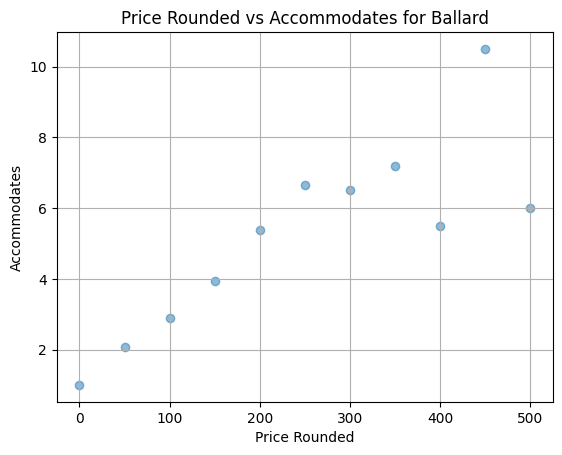

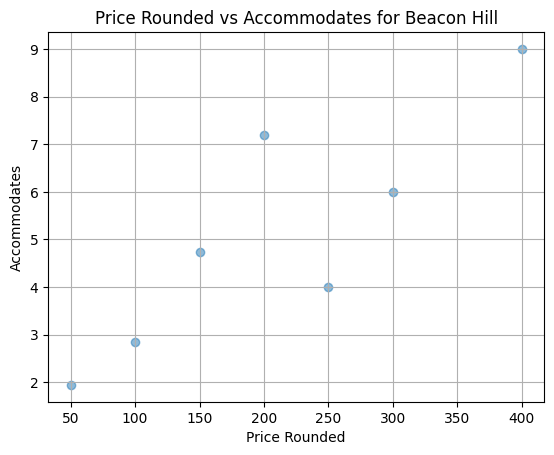

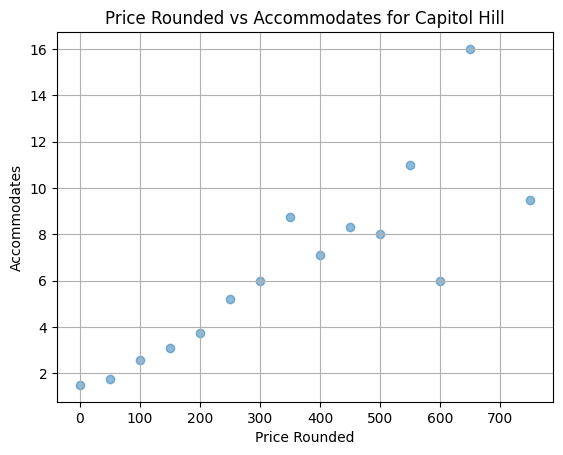

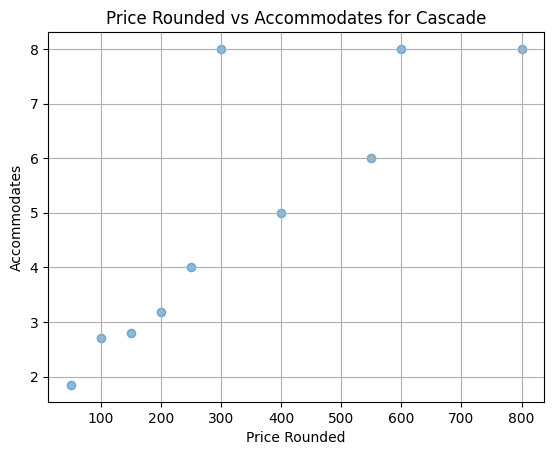

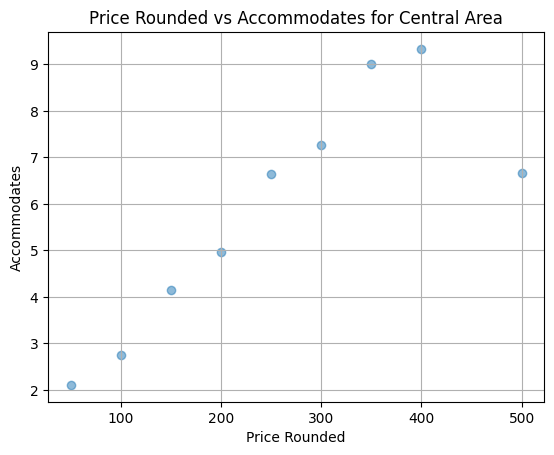

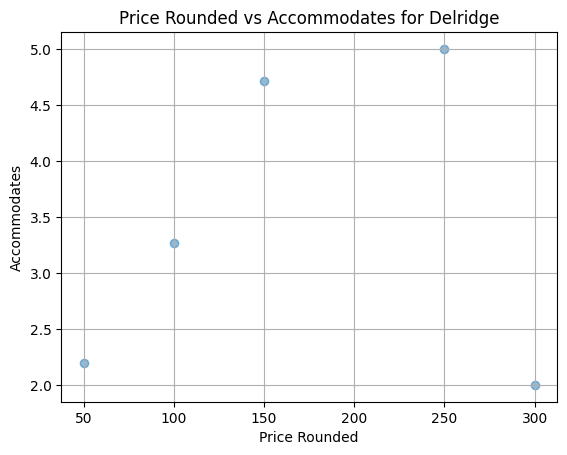

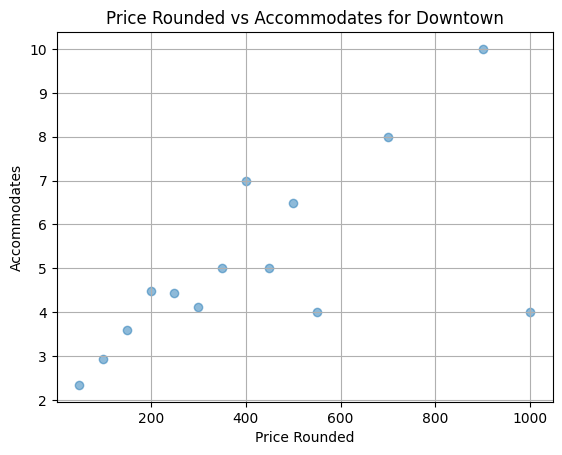

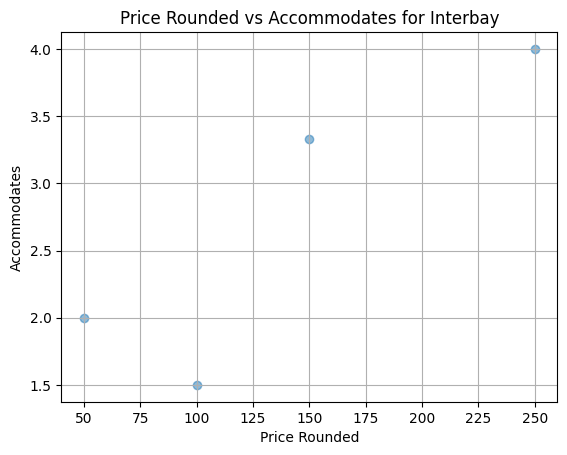

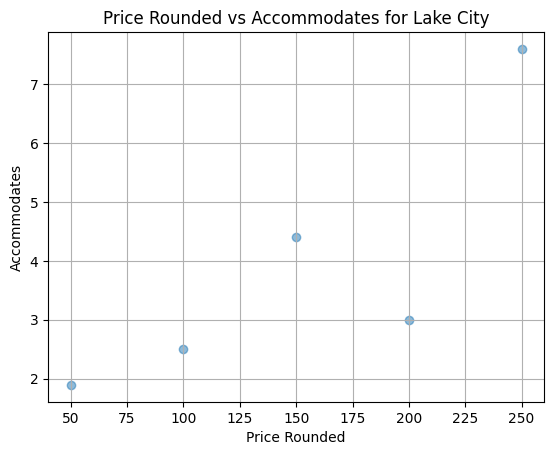

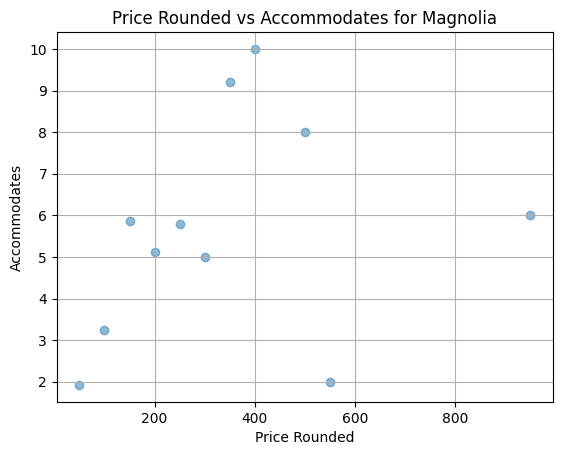

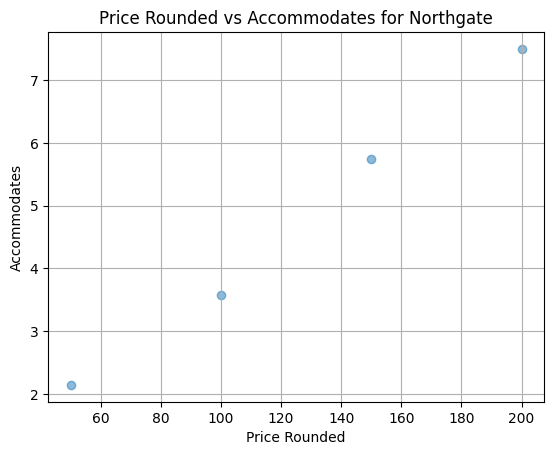

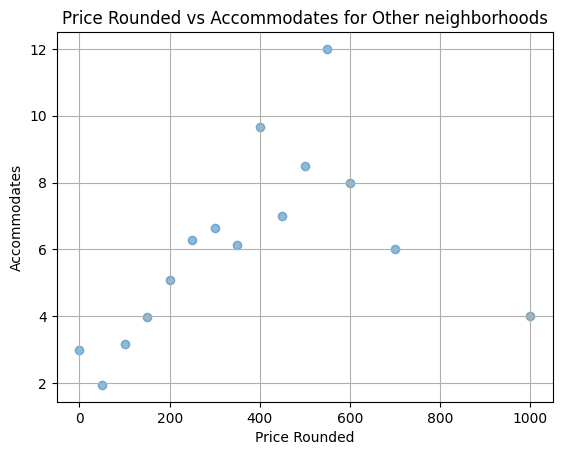

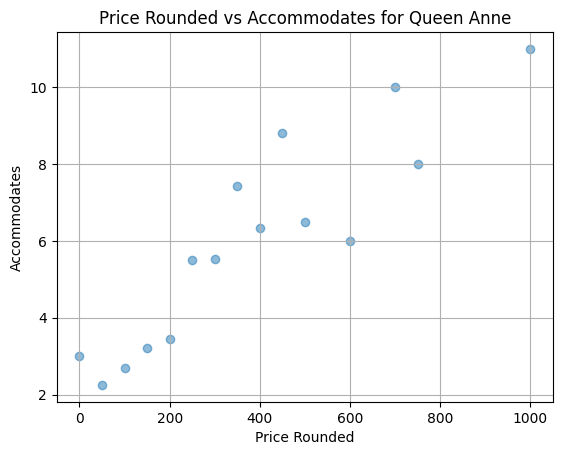

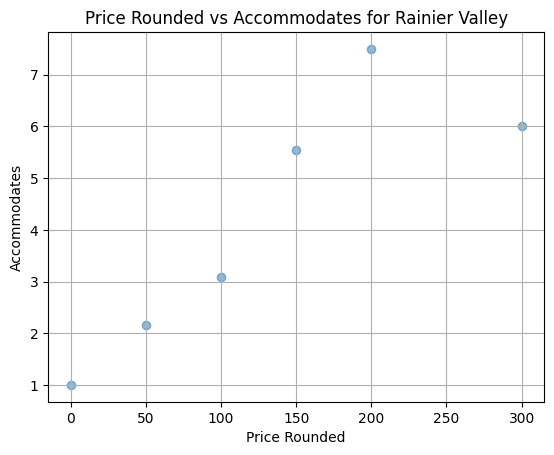

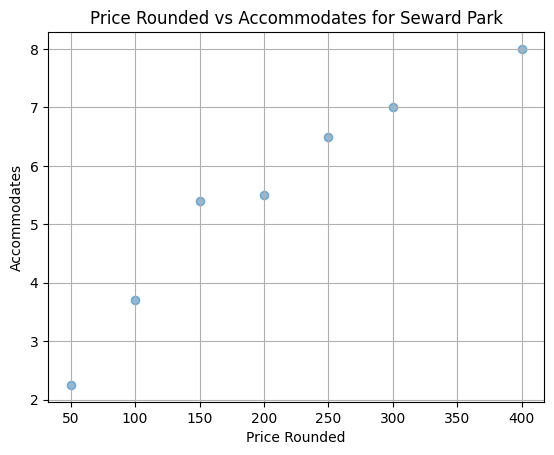

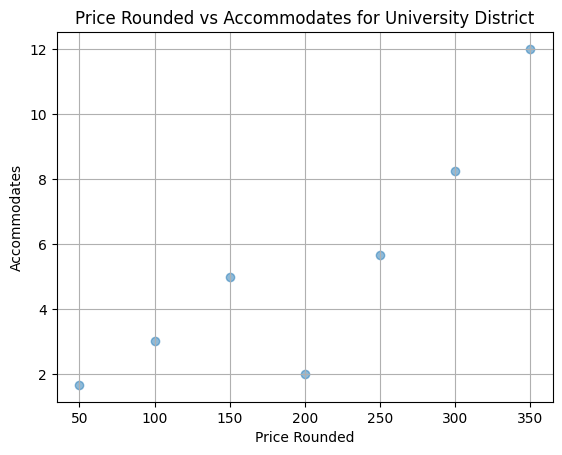

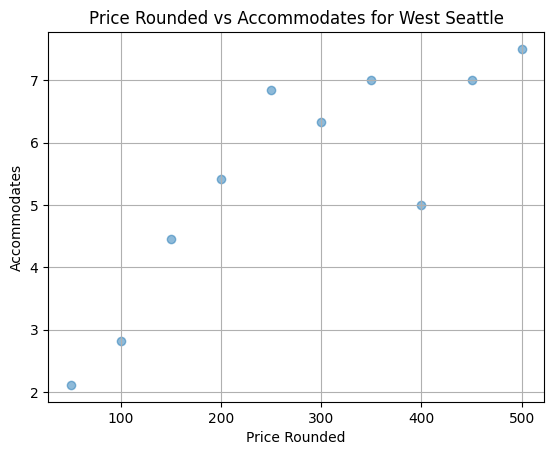

In [18]:
listings_df_revised.reset_index(inplace=True)
towns = listings_df_revised['neighbourhood_group_cleansed'].unique()
for town in towns:
    town_df = listings_df_revised[listings_df_revised['neighbourhood_group_cleansed'] == town]
    create_scatter_plot(town_df['price_rounded'], town_df['accommodates'], 'Price Rounded', 'Accommodates', f'Price Rounded vs Accommodates for {town}')
    

Let's summarise this in an easier way for the client.  I will create correlation scores by neighbourhood and then a simple visual to show which towns have strongest correlation with number of people accommodated.  This will give client more confidence on price.

In [19]:
town_dict = {}


for town in towns:
    
    #filter dataframe for the town to analyse in this loop
    town_df = listings_df_revised[listings_df_revised['neighbourhood_group_cleansed'] == town]

    # Calculate correlation coefficient between 'accommodates' and 'price rounded'
    correlation = town_df['accommodates'].corr(town_df['price_rounded'])

    town_dict[town] = correlation

In [20]:
# Let's make the correlation results into a dataframe

# Convert to DataFrame
town_corr_df = pd.DataFrame.from_dict(town_dict, orient='index', columns=['Correlation_Score'])

# Reset the index to make 'Town' a column
town_corr_df = town_corr_df.reset_index().rename(columns={'index': 'Town'})



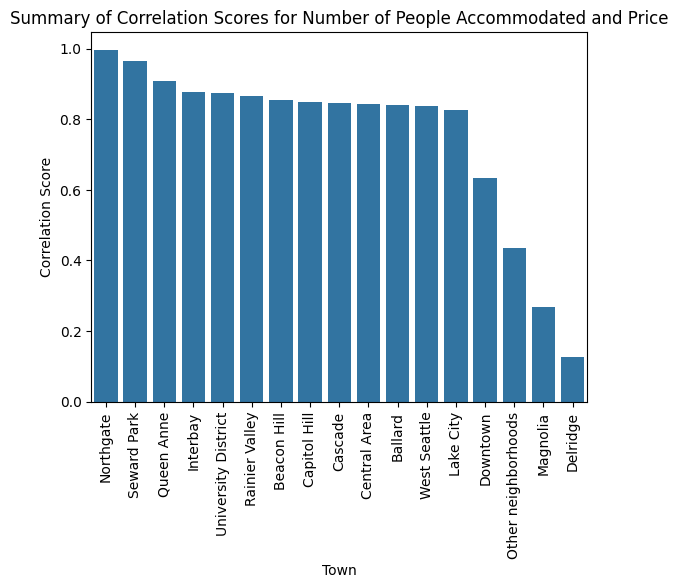

In [21]:
town_corr_df = town_corr_df.sort_values(by='Correlation_Score', ascending=False)

sns.barplot(x='Town', y='Correlation_Score', data=town_corr_df)
plt.xticks(rotation=90)
plt.xlabel('Town')
plt.ylabel('Correlation Score')
plt.title('Summary of Correlation Scores for Number of People Accommodated and Price')
plt.show()

<h2>Step 6 - Deploy The Models</h2>

The original linear regression model is not accurate enough as highlighted earlier.  However, in this final step, I would summarise the key findings for my client.

The executive summary is that:
- There are 17 unique neighbourhoods in Seattle.
- Of these 17 unique neighbourhoods, Magnolia has the highest rentals, followed by Queen Anne and Downtown
- The most common themes or features that impact property rental prices are:  number of people accommodated, bedrooms, beds and bathrooms
- It is difficult to create a universally predictable model for Seattle that would allow prediction of rental prices accurately based on 
  these themes.
- However, if we group into price ranges and use number of people accommodated as a key driver then we see the charts above which show how number of people accommodated impact price.  Of the top 3 neighbourhoods with high prices, Downtown and Queen Anne seem to correlate more strongly between number of people accommodated and price.  Magnolia is less correlated but also has similar directional trends.
- Looking at all neighbourhoods in Seattle, all have a correlation of 80% or more between number of people accommodated and rental price.  The only exceptions are Downtown, Magnolia, Delridge and smaller neighbourhoods (called 'Other neighbourhoods' in dataset).  
- My recommendation to the client is to look at properties that accommodate more people as a way to charge higher rental prices with a focus on the neighbourhoods with a stronger correlation for this factor and price per above.  This would of course need to be compared to the cost of buying the property to make sure the client makes a good return on investment.


